## MLND Capstone :: Carvana Image Masking Challenge

#### Imports

In [15]:
import time

import numpy as np
import pandas as pd
from scipy import ndimage
from tqdm import tqdm

from matplotlib import pyplot as plt
import seaborn as sns

PROJECT_PATH = '.'
INPUT_PATH = PROJECT_PATH + '/input'

METADATA_CSV_PATH = INPUT_PATH + '/metadata.csv'

TRAIN_MASKS_CSV_PATH = INPUT_PATH + '/train_masks.csv'
TRAIN_PATH = INPUT_PATH + '/train'
TRAIN_MASKS_PATH = INPUT_PATH + '/train_masks'

#### IPython options

In [16]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline
%config InlineBackend.figure_format='retina'
%config IPCompleter.greedy=True

#### Read CSV Data

In [3]:
train_masks = pd.read_csv(TRAIN_MASKS_CSV_PATH)
    
metadata = pd.read_csv(METADATA_CSV_PATH)
    
train_masks.head()

img                                           rle_mask
0  00087a6bd4dc_01.jpg  879386 40 881253 141 883140 205 885009 17 8850...
1  00087a6bd4dc_02.jpg  873779 4 875695 7 877612 9 879528 12 881267 15...
2  00087a6bd4dc_03.jpg  864300 9 866217 13 868134 15 870051 16 871969 ...
3  00087a6bd4dc_04.jpg  879735 20 881650 26 883315 92 883564 30 885208...
4  00087a6bd4dc_05.jpg  883365 74 883638 28 885262 119 885550 34 88716...

#### Filename utils

In [4]:
def filename_to_code(filename):
    car_code, angle_code = filename.split('.')[0].split('_')
    return car_code, angle_code

def code_to_filename(car_code, angle_code, mask = False):
    return car_code + '_' + angle_code + ('_mask.gif' if mask else '.jpg')

def get_full_path(filename, mask = False):
    if mask is True:
        return TRAIN_MASKS_PATH + '/' + filename
    else :
        return TRAIN_PATH + '/' + filename
    
def get_filepath_from_code(car_code, angle_code, mask = False):
    return get_full_path(code_to_filename(car_code, angle_code, mask), mask)

#### Image utils

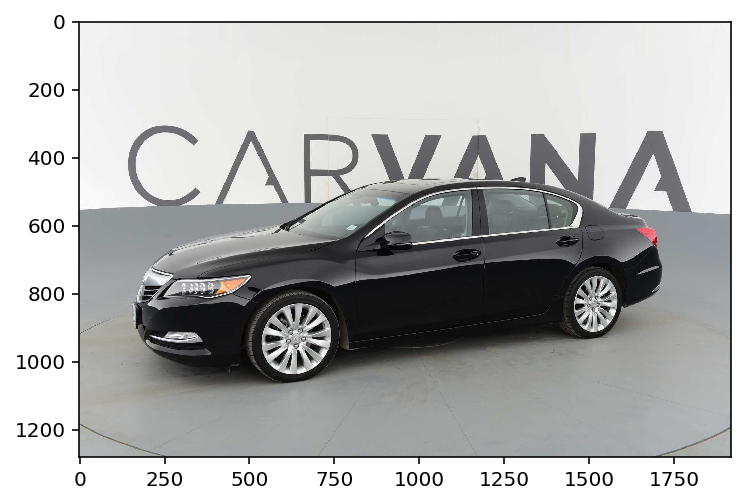

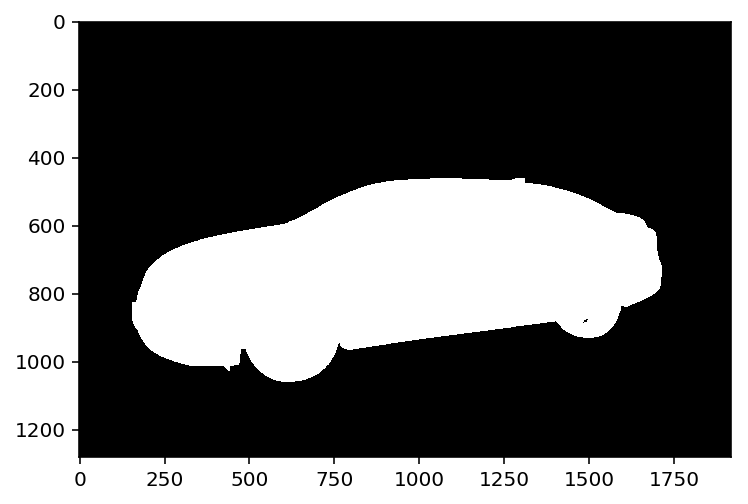

In [17]:
def read_image(car_code, angle_code, mask = False):
    img_path = get_filepath_from_code(car_code, angle_code, mask)
    img = None
    if mask :
        img = ndimage.imread(img_path, mode = 'L')        
        img[img <= 127] = 0
        img[img > 127] = 1        
    else :
        img = ndimage.imread(img_path)
                
    return img

def resize(image):
    

def show_image(car_code, angle_code, mask = False):
    car_img = read_image(car_code, angle_code, mask)    
    plt.imshow(car_img, cmap = 'Greys_r' if mask else None)
    plt.show()

sample_car_code = '00087a6bd4dc'
sample_angle_code = '04'
show_image(sample_car_code, sample_angle_code)    
show_image(sample_car_code, sample_angle_code, True)

In [14]:
car_img = read_image(sample_car_code, sample_angle_code)
car_img.shape

(1280, 1918, 3)

#### Encoder utils

In [ ]:
# https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(mask_image):
    pixels = mask_image.flatten()
    # We avoid issues with '1' at the start or end (at the corners of 
    # the original image) by setting those pixels to '0' explicitly.
    # We do not expect these to be non-zero for an accurate mask, 
    # so this should not harm the score.
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    return runs

def rle_to_string(runs):
    return ' '.join(str(x) for x in runs)


def test_rle_encode():
    test_mask = np.asarray([[0, 0, 0, 0], [0, 0, 1, 1], [0, 0, 1, 1], [0, 0, 0, 0]])
    assert rle_to_string(rle_encode(test_mask)) == '7 2 11 2'
    num_masks = len(train_masks['img'])
    print('Verfiying RLE encoding on', num_masks, 'masks ...')
    time_read = 0.0 # seconds
    time_rle = 0.0 # seconds
    time_stringify = 0.0 # seconds
    for mask_idx in range(num_masks):
        img_file_name = train_masks.loc[mask_idx, 'img']
        car_code, angle_code = filename_to_code(img_file_name)
        t0 = time.clock()
        mask_image = read_image(car_code, angle_code, True)
        time_read += time.clock() - t0
        t0 = time.clock()
        rle_truth_str = train_masks.loc[mask_idx, 'rle_mask']
        rle = rle_encode(mask_image)
        time_rle += time.clock() - t0
        t0 = time.clock()
        rle_str = rle_to_string(rle)
        time_stringify += time.clock() - t0
        assert rle_str == rle_truth_str
        if mask_idx and (mask_idx % 500) == 0:
            print('  ..', mask_idx, 'tested ..')
    print('Time spent reading mask images:', time_read, 's, =>', \
            1000*(time_read/num_masks), 'ms per mask.')
    print('Time spent RLE encoding masks:', time_rle, 's, =>', \
            1000*(time_rle/num_masks), 'ms per mask.')
    print('Time spent stringifying RLEs:', time_stringify, 's, =>', \
            1000*(time_stringify/num_masks), 'ms per mask.')


test_rle_encode()

#### Visualization Utils

In [19]:
import cv2

# Sample some images from the dataset and show them in a grid
def vis_dataset(nrows = 5, ncols = 5, add_masks = False):
    f, ax = plt.subplots(nrows = nrows, ncols = ncols, sharex = True, sharey = True, figsize=(20,20))
    sampled_imgs = np.random.choice(train_masks['img'], nrows*ncols)
#     sampled_imgs = [TRAIN_PATH + '/' + i for i in sampled_imgs]
    
    counter = 0
    for i in range(nrows):
        for j in range(ncols):
            car_code, angle_code = filename_to_code(sampled_imgs[counter])
            image = read_image(car_code, angle_code)
            ax[i, j].imshow(image)
            
            if add_masks:
                mask = read_image(car_code, angle_code, True)
#                 mix = cv2.bitwise_and(image, image, mask = mask)                    
                ax[i, j].imshow(mask, alpha = 0.4)
#                 ax[i, j].imshow(mix, cmap = 'Greys_r', alpha = 0.6)
            counter += 1
    plt.show()

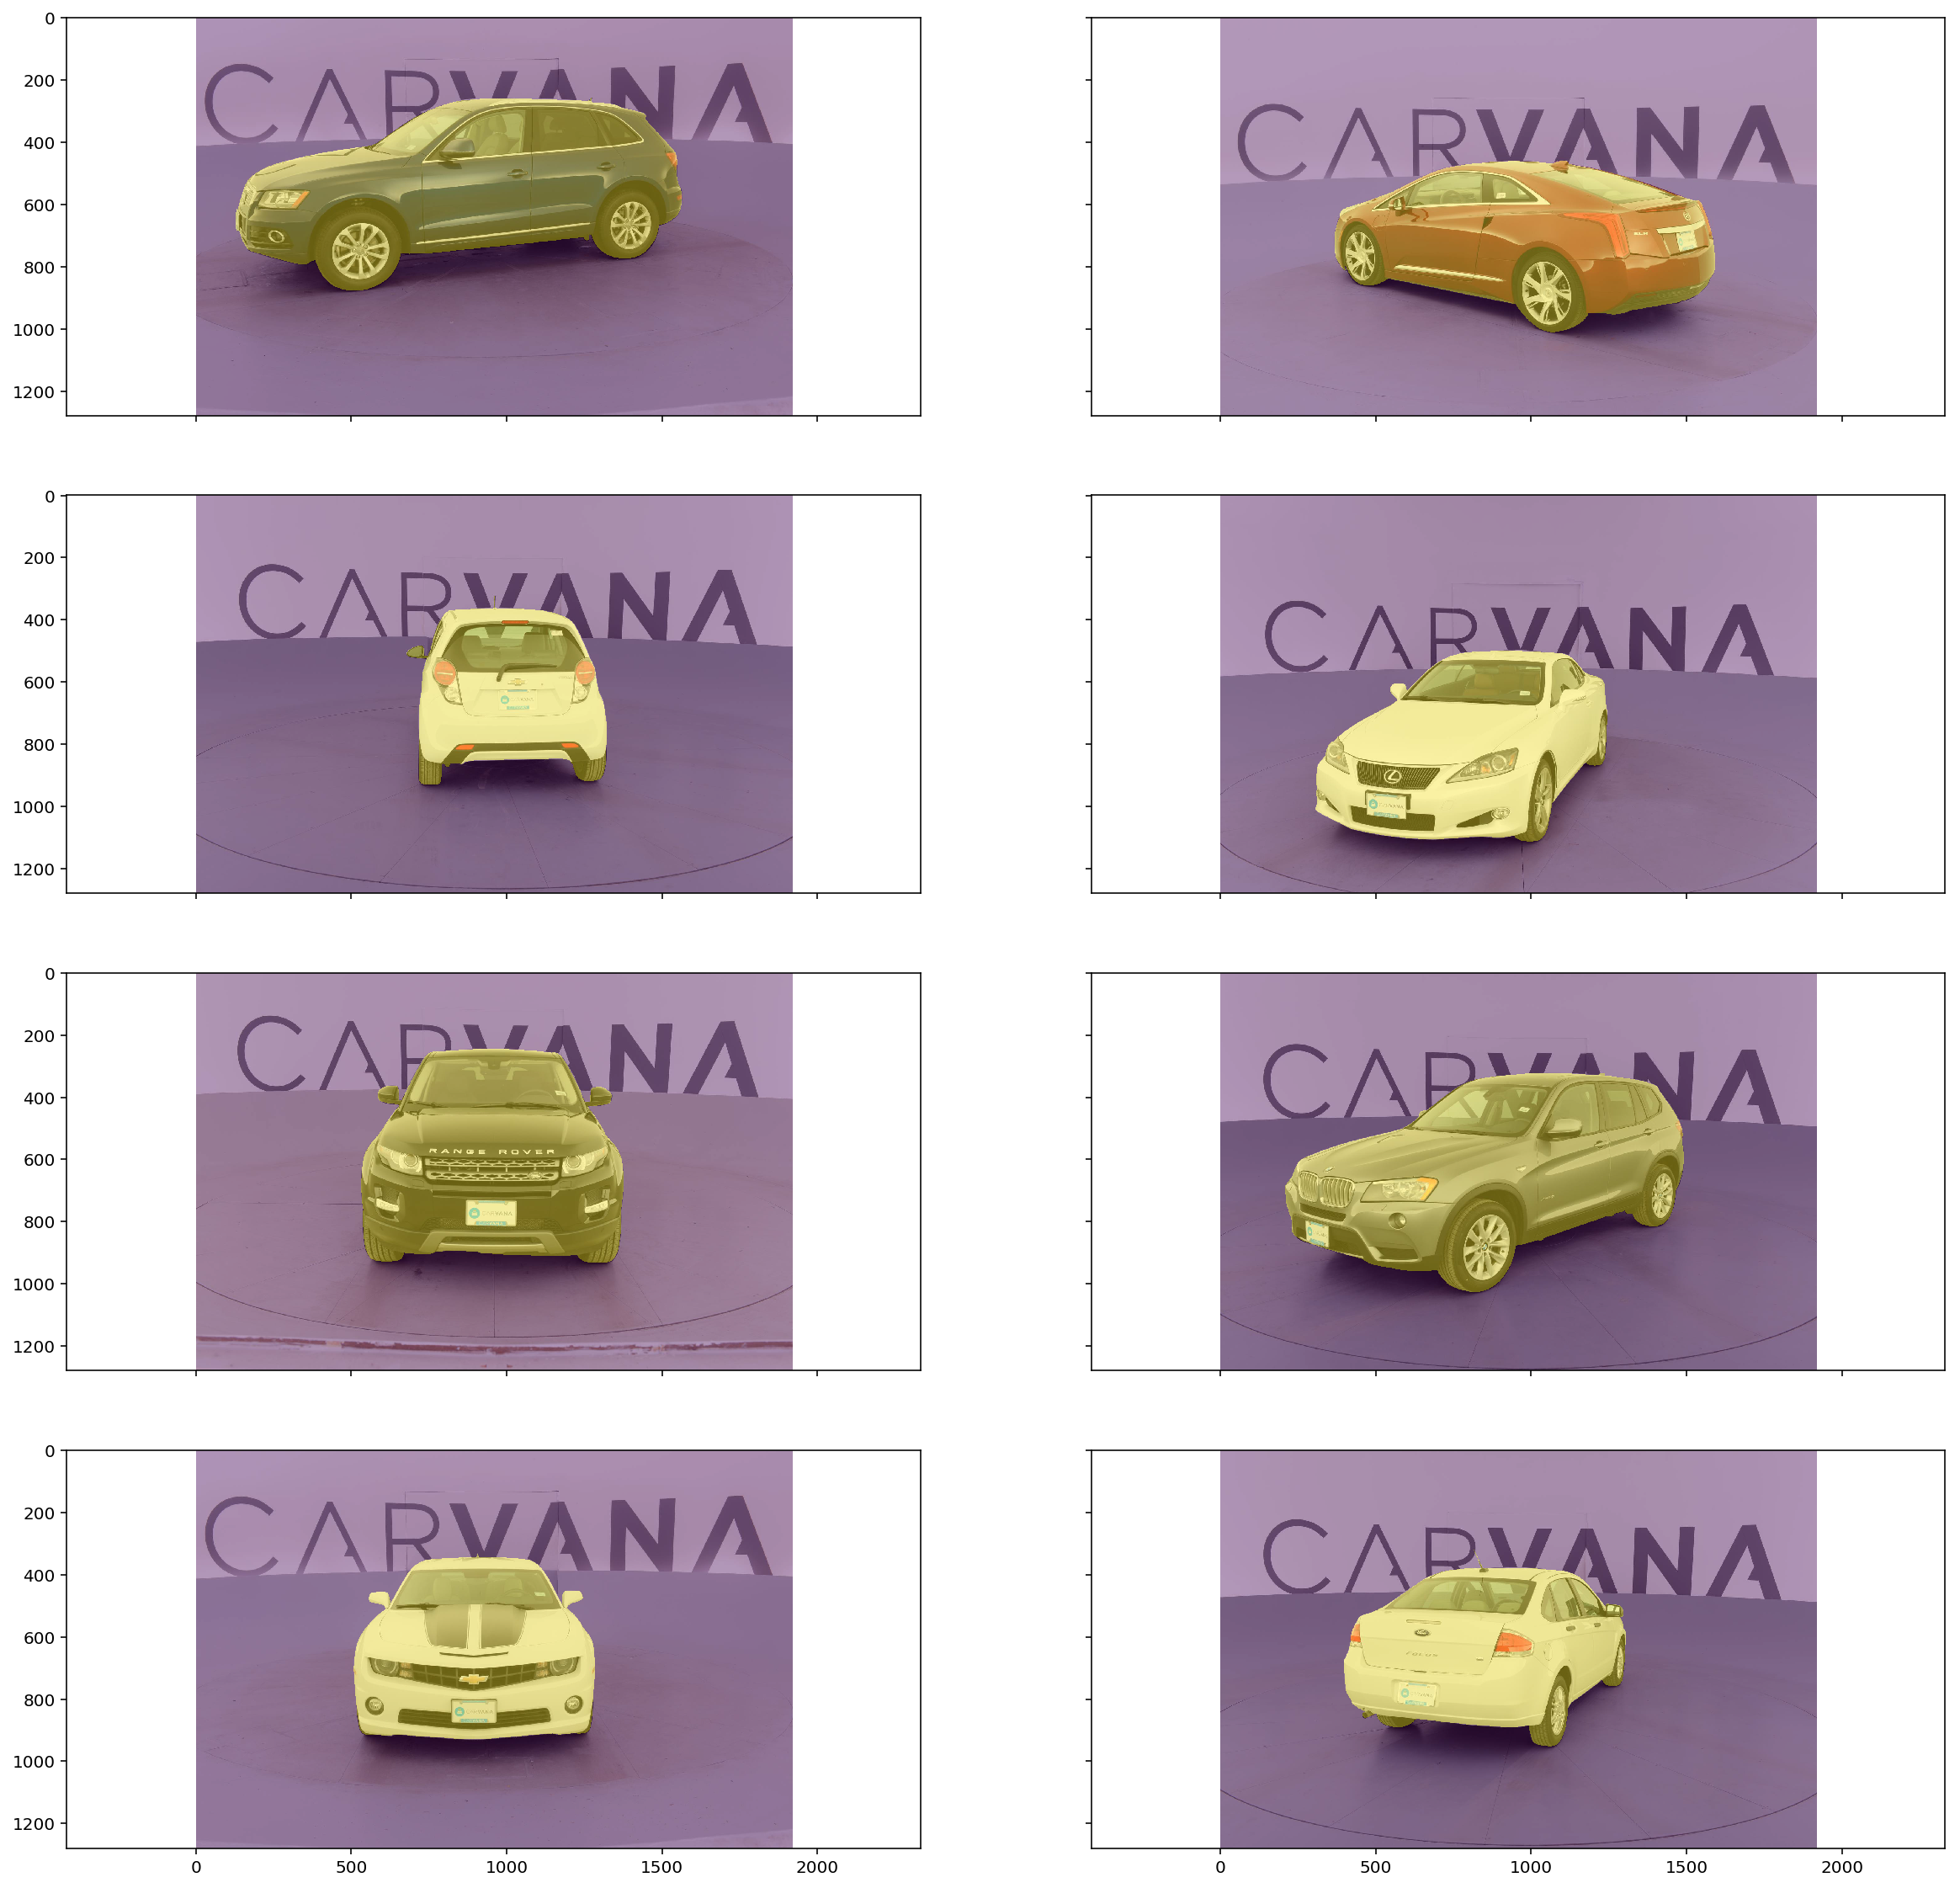

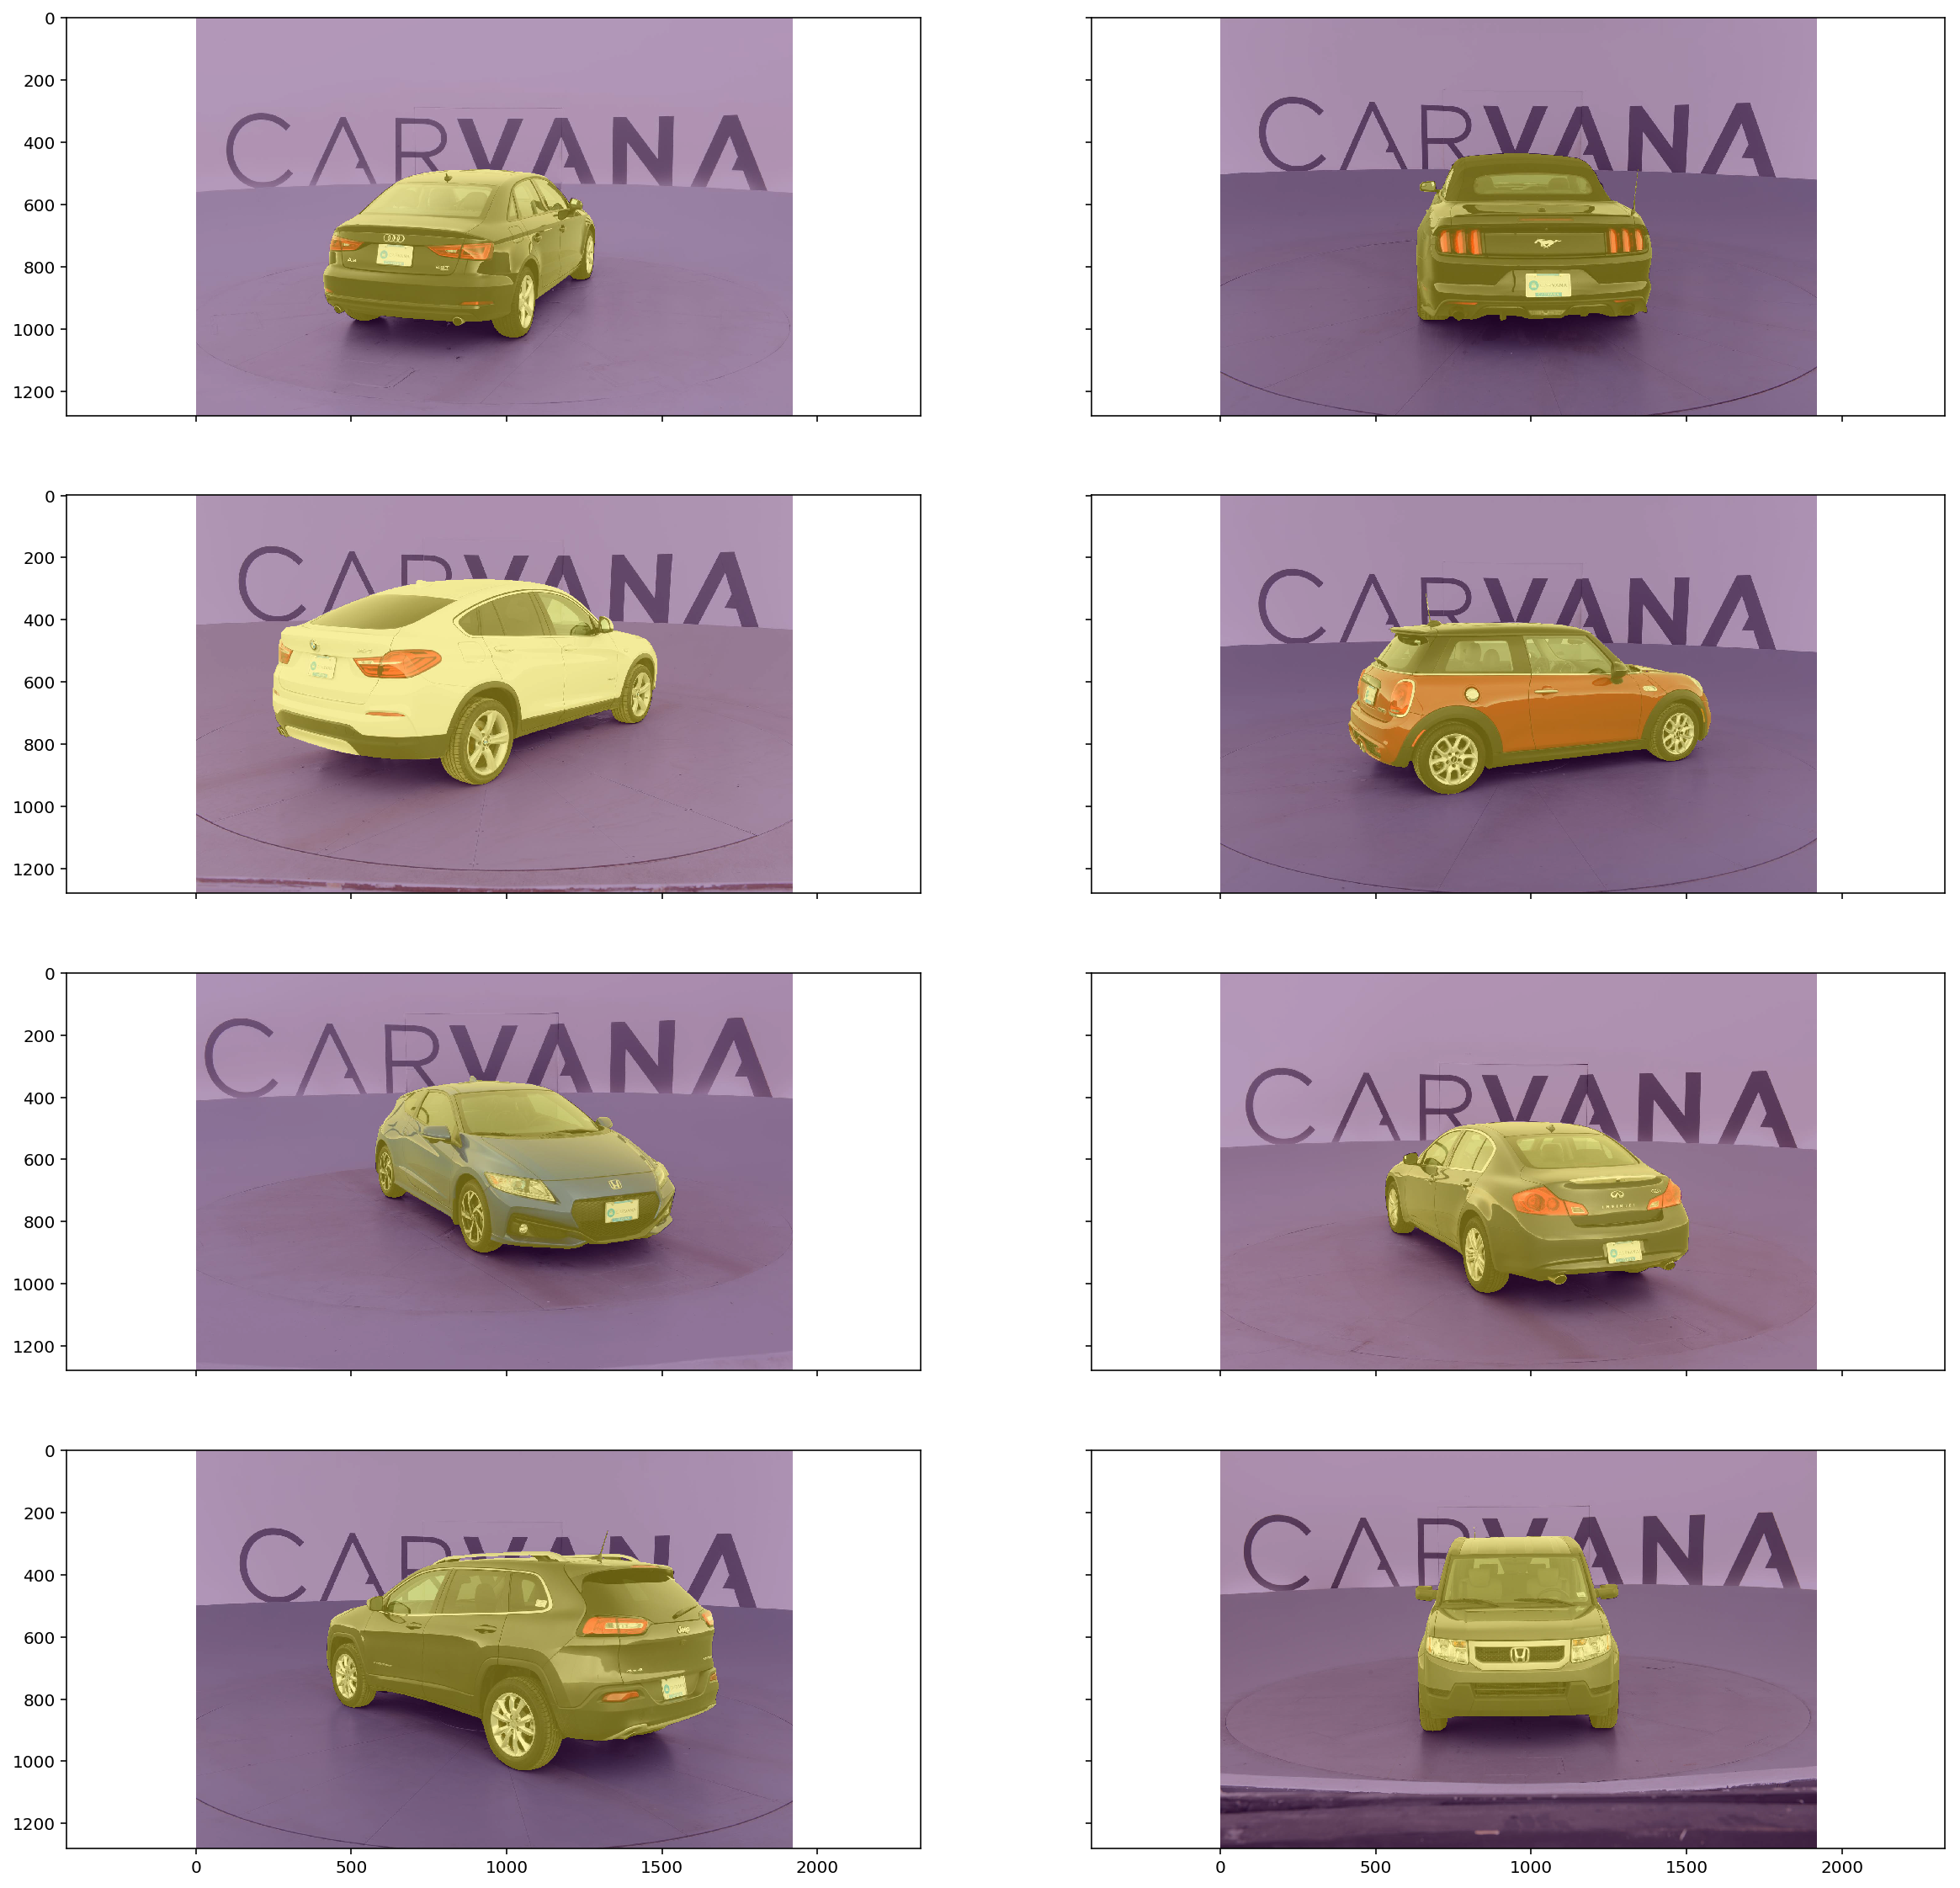

In [25]:
vis_dataset(nrows = 4, ncols = 2, add_masks = True)
vis_dataset(nrows = 4, ncols = 2, add_masks = True)

#### Evaulation Metric

In [26]:
# Evaluation Metric: Dice Coefficient
# Given two vector x and y, returns their dice distance
def dice(x, y):
    return 2*(len(set(x).intersection(set(y))))/(len(set(x)) + len(set(y)))    

#### Car manufacturer ?

In [27]:
metadata.head()
maker = metadata[['id', 'make']].set_index("id")
# sample_car_code
lb = pd.get_dummies(maker).loc[sample_car_code].values
# timg = read_image(sample_car_code, sample_angle_code)
# yield 

id    year       make   model   trim1                    trim2
0  0004d4463b50  2014.0      Acura      TL      TL                     w/SE
1  00087a6bd4dc  2014.0      Acura     RLX     RLX                   w/Tech
2  000aa097d423  2012.0      Mazda  MAZDA6  MAZDA6                  i Sport
3  000f19f6e7d4  2016.0  Chevrolet  Camaro  Camaro                       SS
4  00144e887ae9  2015.0      Acura     TLX     TLX  SH-AWD V6 w/Advance Pkg

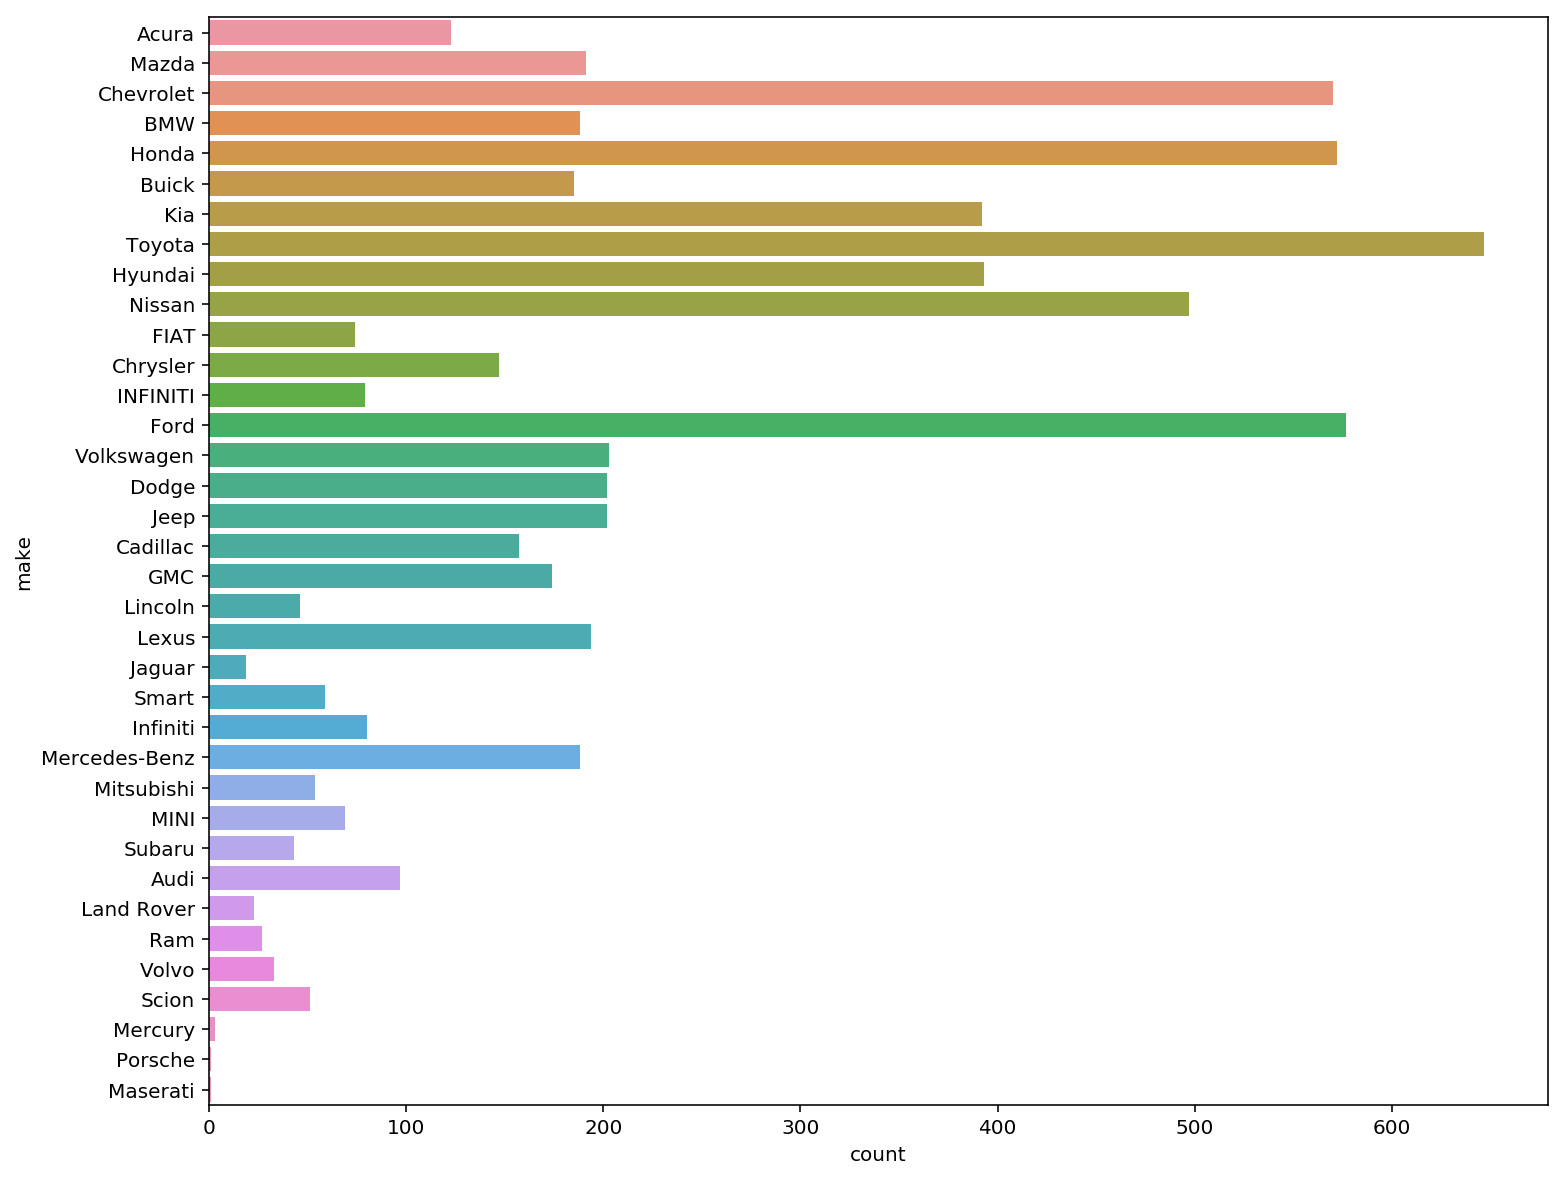

In [29]:

plt.figure(figsize=(12, 10))
sns.countplot(y="make", data=metadata);

In [30]:
from sklearn.model_selection import train_test_split
train_images, validation_images = train_test_split(train_masks['img'], train_size = 0.8)

In [31]:
def train_gen():
    while True:
        img_filename = np.random.choice(train_images)        
        car_code, angle_code = filename_to_code(img_filename)
        img = read_image(car_code, angle_code)/255
        label = pd.get_dummies(maker).loc[car_code].values
#         print("Generated : {}, {}, {}".format(car_code, angle_code, label) )
        yield img.reshape(-1, 1280, 1918, 3), label.reshape(1, -1)

**Make a simple model to predict the maker**

In [41]:
from keras.layers import Dense, Dropout, Conv2D, GlobalAveragePooling2D, MaxPool2D
from keras.models import Model, Sequential
from keras.optimizers import Adam, Adagrad, RMSprop
from keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
from keras.optimizers import tf as KTF
import keras.backend as K


manufacturer_model = Sequential()
manufacturer_model.add(Conv2D(16, kernel_size= (3, 3), activation="relu", input_shape = (1280, 1918, 3)))
manufacturer_model.add(MaxPool2D())
manufacturer_model.add(Conv2D(32, kernel_size = (3, 3), activation = "relu"))
manufacturer_model.add(MaxPool2D())
manufacturer_model.add(Conv2D(64, kernel_size = (3, 3), activation = "relu"))
manufacturer_model.add(MaxPool2D())
manufacturer_model.add(Conv2D(128, kernel_size = (3, 3), activation = "relu"))
manufacturer_model.add(MaxPool2D())
manufacturer_model.add(Conv2D(256, kernel_size = (3, 3), activation = "relu"))
manufacturer_model.add(MaxPool2D())
manufacturer_model.add(Conv2D(512, kernel_size = (3, 3), activation = "relu"))
manufacturer_model.add(MaxPool2D())
manufacturer_model.add(GlobalAveragePooling2D())
manufacturer_model.add(Dense(36, activation = 'softmax')) # Number of makers in the dataset

In [39]:
manufacturer_model.compile(optimizer = Adam(), loss = 'categorical_crossentropy', metrics = ['accuracy'])


In [ ]:
model.fit_generator(train_gen(), steps_per_epoch=len(train_masks), epochs = 10, validation_steps=100)

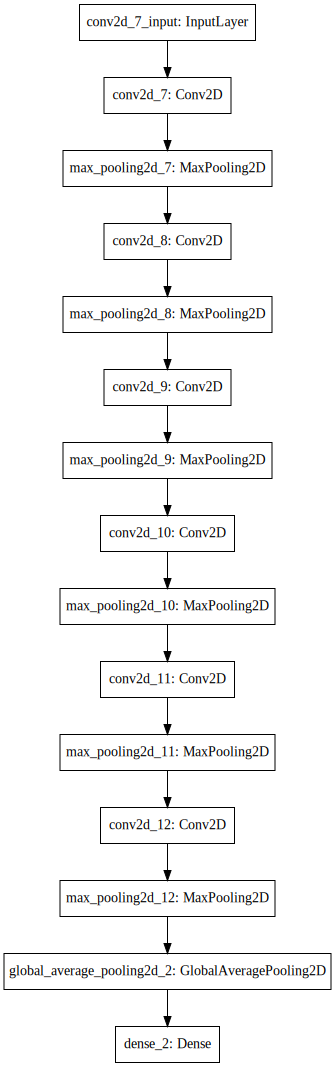

In [40]:
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# plot_model(model, to_file='manufaturer_model.png')
SVG(model_to_dot(manufacturer_model).create(prog='dot', format='svg'))

#### Baseline

In [42]:
baseline_model = Sequential()
baseline_model.add( Conv2D(16, 3, activation='relu', padding='same', input_shape=(320, 480, 12)) )